# Handcrafting Features for Handwritten Numbers

We will use a subset of the MNIST (Modified National Institute of Standards and Technology) dataset for handwritten digits. Each input character is represented in a 28*28 array. We attempt to extract some simple features from these images which can help us distinguish between the digits.

In [17]:
# Data-handling and learning libraries
import numpy as np
from numpy import log, dot, e
from numpy.random import rand
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
# Plotting libraries
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

In [18]:
from keras.datasets import mnist 
#loading the dataset
(train_X, train_y), (test_X, test_y) = mnist.load_data()

Extract a subset of the data for our experiment.    
We intend to distinguish between 0s and 1s in this experiment.

In [19]:
# Extract the images of 0s and 1s only
no1 = train_X[train_y==1,:,:]
no0 = train_X[train_y==0,:,:]
print(no1.shape)

(6742, 28, 28)


Let's quickly visualize a few images from the dataset

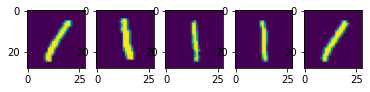

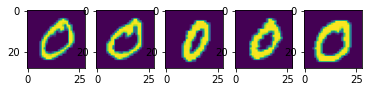

In [20]:
for ii in range(5):
  plt.subplot(1, 5, ii+1)
  plt.imshow(no1[ii,:,:])
plt.show()

for ii in range(5):
  plt.subplot(1, 5, ii+1)
  plt.imshow(no0[ii,:,:])
plt.show()

We now start **extracting features**, based on our intuition of what will help distinguish well between the classes of images we are considering (0s and 1s).

The **intention** is to push the group of images from each class apart on the feature-space - with as minimal an overlap possible. Given a new image, we simply compute that feature for it and find which set it relates to better.

**Note** that with these handrcrafted features, we follow a rough intuition without venturing too deep into their generalizability, subtle effects on other features and so on

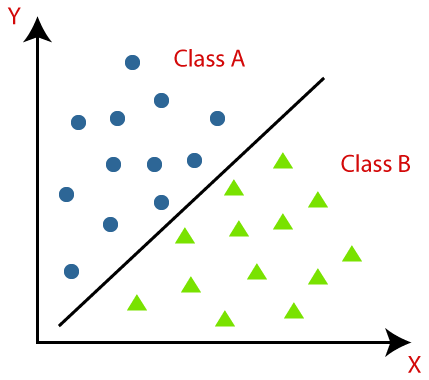

### Feature 1 : Sum

**Idea**: The digit is the only obvious non-background element in each image. Each digit needs a different range of active pixels (non-zero) to denote it. (Assuming, of course, that the digit occupies roughly the same portion in all images!)

**Feature**: Sum up all the postive-valued pixels. We expect that 0s would generally require more pixels than 1s. Keeping things terse, let's call it the **sum** feature

In [21]:
# Sum only +ve pixels
sum1 = np.sum(no1>0, (1,2)) # threshold before adding up
sum0 = np.sum(no0>0, (1,2))

But how good is it?   
Let's plot a histogram: the sum feature on x-axis, the frequency on y-axis

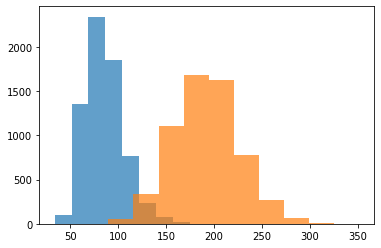

In [22]:
plt.hist(sum1, alpha=0.7);
plt.hist(sum0, alpha=0.7);

Although there is some overlap, this feature seems to separate the two classes quite well.


### Feature 2 : Holes (and Hulls)

**Idea**: 0 forms a closed curve when written perfectly, while 1 does not. So there must be several black pixels enclosed within the digit on an image of 0. This won't be the case with 1s.

**Feature**: Count the number black pixels that are surrounded on four sides by non-black pixels. We are calling this feature - **holes**. In the process, we generate something else called a **hull** as well!

In [23]:
def cumArray(img):
  img2 = img.copy()
  for ii in range(1, img2.shape[1]):
    img2[ii,:] = img2[ii,:] + img2[ii-1,:]  # for every row, add up all the rows above it.
  img2 = img2>0
  return img2

def getHolePixels(img):
  im1 = cumArray(img)
  # rotate, cumulate, rotate back - in all directions
  im2 = np.rot90(cumArray(np.rot90(img)), 3) 
  im3 = np.rot90(cumArray(np.rot90(img, 2)), 2)
  im4 = np.rot90(cumArray(np.rot90(img, 3)), 1)
  # only pixels with no non-zero pixels on any side will remain zero now
  hull =  im1 & im2 & im3 & im4
  hole = hull &~ (img>0)
  return hole, hull

Let's visualize a sample each to make things obvious and explicit

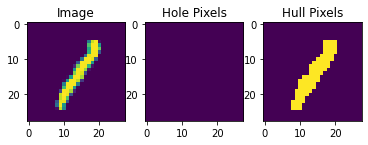

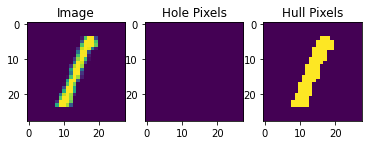

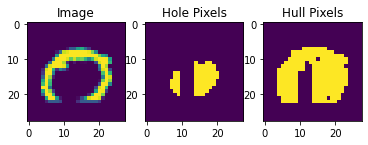

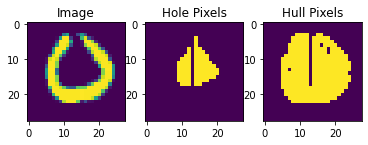

In [24]:
imgs = [no1[456,:,:], no1[288,:,:],  no0[456,:,:], no0[288,:,:]]
for img in imgs:
  hole, hull = getHolePixels(img)
  plt.subplot(1,3,1)
  plt.gca().set_title('Image')
  plt.imshow(img)
  plt.subplot(1,3,2)
  plt.gca().set_title('Hole Pixels')
  plt.imshow(hole)
  plt.subplot(1,3,3)
  plt.gca().set_title('Hull Pixels')
  plt.imshow(hull)
  plt.show()

Essentially, *hole-pixels + digit-pixels = hull-pixels*   
(Please refer to the implementation of `getHolePixels(...)` function for more clarity)     

    
Since the hull and hole features pretty much convey the same information, there is no discriminatory advantage in using both of them together. We choose one arbitrarily - the **hole** feature.

Once again, we plot a histogram to see how useful this feature is.   
The hole feature on x-axis, the frequency of images on y-axis

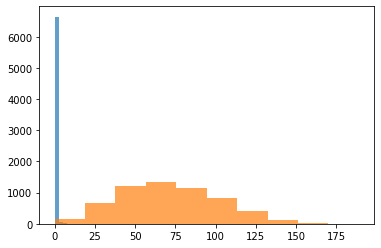

In [25]:
hole1 = np.array([getHolePixels(i)[0].sum() for i in no1])
hole0 = np.array([getHolePixels(i)[0].sum() for i in no0])
  
plt.hist(hole1, alpha=0.7);
plt.hist(hole0, alpha=0.7);

Well, that's even better! There is much lesser overlap.

Further, our intuition at the start where we hypothesized that 1s would hardly have any hole pixles is confirmed by that *narrow long blue bar* in the histogram!

### Feature 3 : Boundary

Let us try one more feature, where we look at the number of boundary pixels in each image.

In [26]:
def minus(a, b):
  return a & ~ b

def getBoundaryPixels(img):
  img = img.copy()>0  # binarize the image
  rshift = np.roll(img, 1, 1)
  lshift = np.roll(img, -1 ,1)
  ushift = np.roll(img, -1, 0)
  dshift = np.roll(img, 1, 0)
  # At least one adjacent pixel must be non-zero for a boundary. This is detected by the procedure
  boundary = minus(img, rshift) | minus(img, lshift) | minus(img, ushift) | minus(img, dshift)
  return boundary

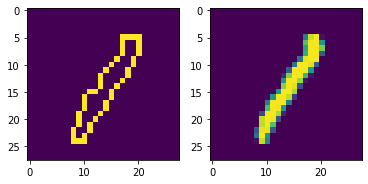

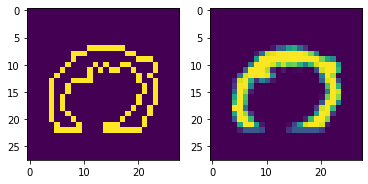

In [27]:
imgs = [no1[456,:,:],  no0[456,:,:]]
for img in imgs:
  plt.subplot(1,2,1)
  plt.imshow(getBoundaryPixels(img))
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.show()

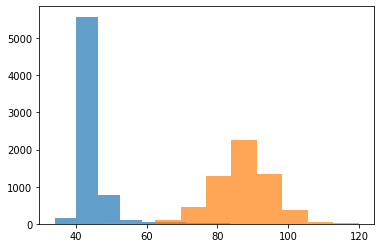

In [28]:
bound1 = np.array([getBoundaryPixels(i).sum() for i in no1])
bound0= np.array([getBoundaryPixels(i).sum() for i in no0])

plt.hist(bound1, alpha=0.7);
plt.hist(bound0, alpha=0.7);

Plotting two features together

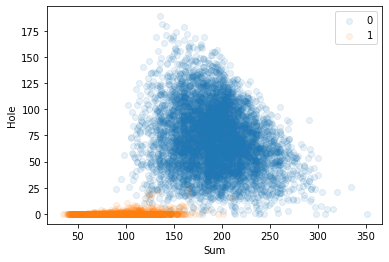

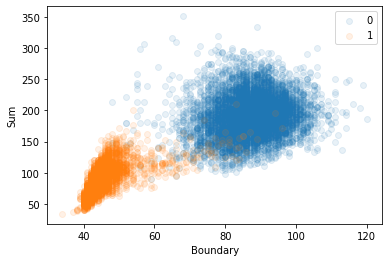

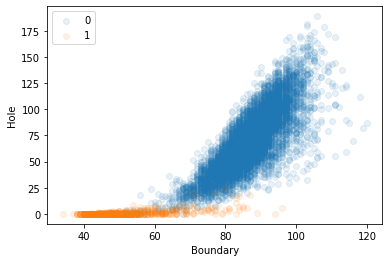

In [31]:
# Sum and hole
plt.scatter(sum0, hole0, alpha=0.1)
plt.scatter(sum1, hole1, alpha=0.1)
plt.xlabel('Sum');
plt.ylabel('Hole');
plt.legend(['0','1'])
plt.show()

# Sum and Boundary
plt.scatter(bound0, sum0, alpha=0.1)
plt.scatter(bound1, sum1, alpha=0.1)
plt.xlabel('Boundary');
plt.ylabel('Sum');
plt.legend(['0','1'])
plt.show()

# Hole and boundary
plt.scatter(bound0, hole0, alpha=0.1)
plt.scatter(bound1, hole1, alpha=0.1)
plt.xlabel('Boundary');
plt.ylabel('Hole');
plt.legend(['0','1'])
plt.show()

Plotting all 3 features together.

In [32]:
cl1 = ['class 1']*len(sum1)
cl0 = ['class 0']*len(sum0)
df = pd.DataFrame(list(zip(np.concatenate((hole0, hole0)), np.concatenate((sum1,sum0)), 
                           np.concatenate((bound1,bound0)), np.concatenate((cl1, cl0)))),
               columns =['Hole', 'Sum', 'Boundary', 'Class'])
print(df.head())
fig = px.scatter_3d(df, x='Hole', y='Sum', z='Boundary', color='Class', opacity=0.1)
fig.show()

   Hole  Sum  Boundary    Class
0    72   96        46  class 1
1    65   93        45  class 1
2    23   68        42  class 1
3    24   75        43  class 1
4    74   95        42  class 1



Now we apply logistic regression over these handcrafted features to learn a decision boundary that can separate these two classes of images apart!

# Logistic Regression Algorithm

- Supervised learning algorithm to solve classification problems
- Called regression since the underlying technique is similar to linear regression
- Called logistic due to the use of the logit function (sigmoid function) in the algorithm, which we will see soon
- The dependent (target) variable is in the form of discrete classes
- Binary Logistic Regression will be dealt with, today
- Eg. Classifying mail as spam, non-spam



## Logistic Regression Implementation

In [68]:
class LogisticRegressionScratch(object):
    """Class for Logistic Regression."""
    
    def __init__(self):
        """ theta  -- Parameters (initialised in fit method)
            losses -- list of losses to add during training. 
        """
        self.theta = None
        self.losses = []
    
    def sigmoid(self, z):
        """Activation function"""
        z=z.astype(float)
        return 1/(1 + np.exp(-z))    
        
    def predict(self, X):
        """Return predictions based on current parameters."""
        return self.sigmoid(X.dot(self.theta))

    def loss(self, X, y):
        """Return log loss function value to optimise."""
        return (-y * np.nan_to_num(np.log(self.predict(X))) - (1 - y) * np.nan_to_num(np.log(1 - self.predict(X)))).mean()

    def gradient(self, X, y):
        """Return the gradient of the loss function."""
        return (1/(2 * X.shape[0])) * X.T.dot(self.predict(X) - y)

    def fit(self, X_train, y_train, lr=0.01, num_iter=1000, epochs=1):
        """Fit a Logistic Regression model on the given data.
           X_train  -- train data (m * n matrix)
           y_train  -- labels (m-dim vector of 1s/0s)
           lr       -- learning rate (default 0.01)
           num_iter -- number of iterations to run (default 1000)
           epochs   -- number of times to iterate over data (default 10)
           Return: None
        """
        self.theta = np.random.randn(X_train.shape[1])
        for epoch in range(epochs):
            for _ in range(num_iter):
                op = self.predict(X_train)
                self.theta -= (lr * (self.gradient(X_train, y_train)).astype('float64'))
                self.losses.append(self.loss(X_train, y_train))

## Decision Boundary Visualizer Functions

In [34]:
def plot_decision_boundary(weights, figure, data, reqd_features=['Hole', 'Sum']):

  def predict_val(features):
    model= LogisticRegressionScratch()
    features = np.hstack((np.ones((features.shape[0], 1)), features))
    print(features.shape, weights.shape)
    z = dot(features, weights)
    return model.sigmoid(z.astype(float))

  def plot_surface():
    features_range = np.array([np.arange(features[feat].min()-50, features[feat].max()+50, 10) for feat in reqd_features]).T
    xx, yy = np.meshgrid(features_range[0], features_range[1])
    predictions = predict_val(np.c_[xx.ravel(), yy.ravel()])
    predictions = predictions.reshape(xx.shape)
    figure.add_trace(go.Surface(x=features_range[0], y=features_range[1], z=predictions))
    return figure                  
  
  features = data[reqd_features]
  class_ = data['Class']
  if len(reqd_features) == 2:
    return plot_surface()

In [35]:
def plot_decision_boundary_alt(X, y, weights, plot):

  def predict_val(features):
    model= LogisticRegressionScratch()
    features = np.hstack((np.ones((features.shape[0], 1)), features))
    print(features.shape, weights.shape)
    z = dot(features, weights)
    return model.sigmoid(z.astype(float))

  try:
      X = np.array(X)
      y = np.array(y).flatten()
      y[y=='class 1'] = 1
      y[y=='class 0'] = 0
  except:
    print("Coercing to NumPy arrays failed")
    # Reduce to the first two columns of data
  reduced_data = X[:, :2]
  h = 10  

  x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
  y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                        np.arange(y_min, y_max, 0.1))

  # Predictions to obtain the classification results
  Z = predict_val(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

  # Plotting

  plot.scatter(X[:, 0], X[:, 1], c=y, alpha=0.8)
  plot.contourf(xx, yy, Z, alpha=0.4)
  plot.xlabel("Feature A")
  plot.ylabel("Feature B")
  return plot

## Training the Classifiers

Having set up the classifiers, let's train them with different combinations of features

In [37]:
data = df.to_numpy()
print(df)
X_train, X_test, y_train, y_test= train_test_split(data[:, :3], (data[:,3]=='class 1').astype(int), test_size=0.2, random_state=0)
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
print(X_train)
print(y_train)
print(X_test.shape)
print(y_test.shape)

       Hole  Sum  Boundary    Class
0        72   96        46  class 1
1        65   93        45  class 1
2        23   68        42  class 1
3        24   75        43  class 1
4        74   95        42  class 1
...     ...  ...       ...      ...
11841    65  158        98  class 0
11842    47  220        91  class 0
11843    46  193        95  class 0
11844    41  138        89  class 0
11845    67  205        84  class 0

[11846 rows x 4 columns]
[[1.0 52 79 44]
 [1.0 73 91 44]
 [1.0 101 53 43]
 ...
 [1.0 66 137 81]
 [1.0 77 191 95]
 [1.0 61 106 46]]
[1 1 1 ... 0 0 1]
(2370, 4)
(2370,)


## One Feature Classifier

Let us check for the accuracy when a singular feature is taken into consideration:

In [ ]:
# first feature: Hole
X_train, X_test, y_train, y_test= train_test_split(data[:, 0:1], (data[:,3]=='class 1').astype(int), test_size=0.2, random_state=0)
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])
model= LogisticRegressionScratch()
model.fit (X_train, y_train)

pred= model.predict(X_test)
accuracy_hole = ((pred>0.5)==y_test).mean()

print("Accuracy with hole feature considered: %.3f" % accuracy_hole)

# second feature: Sum
X_train, X_test, y_train, y_test= train_test_split(data[:, 1:2], (data[:,3]=='class 1').astype(int), test_size=0.2, random_state=0)
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])

model= LogisticRegressionScratch()
model.fit (X_train, y_train)

pred= model.predict(X_test)
accuracy_sum = ((pred>0.5)==y_test).mean()

print("Accuracy with sum feature considered: %.3f" % accuracy_sum)

# third feature: Boundary
X_train, X_test, y_train, y_test= train_test_split(data[:, 2:3], (data[:,3]=='class 1').astype(int), test_size=0.2, random_state=0)
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])

model= LogisticRegressionScratch()
model.fit (X_train, y_train)

pred= model.predict(X_test)
accuracy_boundary = ((pred>0.5)==y_test).mean()

print("Accuracy with boundary feature considered: %.3f" % accuracy_boundary)


## Two Feature Classifier

### i) Hole and Sum Features

In [67]:
# first feature set: Hole & Sum
X_train, X_test, y_train, y_test= train_test_split(data[:, 0:2], (data[:,3]=='class 1').astype(int), test_size=0.2, random_state=0)
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])

model= LogisticRegressionScratch()
model.fit (X_train, y_train)

pred= model.predict(X_test)
accuracy_hole_sum = ((pred>0.5)==y_test).mean()

print("Accuracy with hole and sum features considered: %.3f" % accuracy_hole_sum)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning:

overflow encountered in reduce



Accuracy with hole and sum features considered: 0.739


In [69]:
md = LogisticRegression()
md.fit(X_train[:, 1:], y_train)
pred = md.predict(X_test[:, 1:])
accuracy = np.sum(y_test==pred)/len(y_test)

print("The accuracy is %.3f" % accuracy)

The accuracy is 0.971


(1218, 3) (3,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(6092900, 3) (3,)


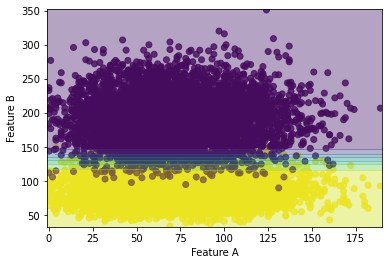

In [70]:
from matplotlib import pyplot as plot

# Plot the classifier results
cl1 = ['class 1']*len(sum1)
cl0 = ['class 0']*len(sum0)
df = pd.DataFrame(list(zip(np.concatenate((hole0, hole0)), np.concatenate((sum1,sum0)), 
                           np.concatenate((bound1,bound0)), np.concatenate((cl1, cl0)))),
               columns =['Hole', 'Sum', 'Boundary', 'Class'])

scikit_theta = np.hstack((md.intercept_, md.coef_[0]))

fig = px.scatter_3d(df, x='Hole', y='Sum', z=[0.5 for x in range(len(df['Sum']))], color='Class')
fig = plot_decision_boundary(scikit_theta, fig, df, ['Hole', 'Sum'])
fig.show()

plot = plot_decision_boundary_alt(df[['Hole', 'Sum']], df['Class'], scikit_theta, plot)
plot.show()

### ii) Sum and Boundary Features

In [71]:
# second feature set: Sum & Boundary
X_train, X_test, y_train, y_test= train_test_split(data[:, 1:3], (data[:,3]=='class 1').astype(int), test_size=0.2, random_state=0)
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])

model= LogisticRegressionScratch()
model.fit (X_train, y_train)

model.predict (X_test)
accuracy_sum_boundary = ((pred>0.5)==y_test).mean()

print("Accuracy with sum and boundary features considered: %.3f" % accuracy_sum_boundary)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning:

overflow encountered in reduce



Accuracy with sum and boundary features considered: 0.971


In [72]:
md = LogisticRegression()
md.fit(X_train[:, 1:], y_train)
pred = md.predict(X_test[:, 1:])
accuracy = np.sum(y_test==pred)/len(y_test)

print("The accuracy is %.3f" % accuracy)

The accuracy is 0.993


(798, 3) (3,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(2807200, 3) (3,)


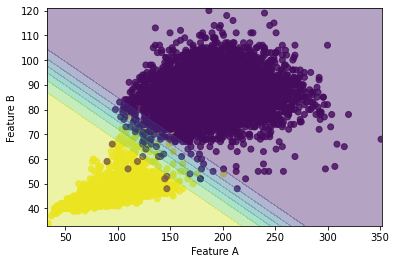

In [74]:
from matplotlib import pyplot as plot

# Plot the classifier results
cl1 = ['class 1']*len(sum1)
cl0 = ['class 0']*len(sum0)
df = pd.DataFrame(list(zip(np.concatenate((hole0, hole0)), np.concatenate((sum1,sum0)), 
                           np.concatenate((bound1,bound0)), np.concatenate((cl1, cl0)))),
               columns =['Hole', 'Sum', 'Boundary', 'Class'])

scikit_theta = np.hstack((md.intercept_, md.coef_[0]))

fig = px.scatter_3d(df, x='Sum', y='Boundary', z=[0.5 for x in range(len(df['Sum']))], color='Class')
fig = plot_decision_boundary(scikit_theta, fig, df, ['Sum', 'Boundary'])
fig.show()

plot = plot_decision_boundary_alt(df[['Sum', 'Boundary']], df['Class'], scikit_theta, plot)
plot.show()

### iii) Boundary and Hole Features

In [75]:
# third feature set: Boundary & Hole
X_train, X_test, y_train, y_test= train_test_split(data[:, :3:2], (data[:,3]=='class 1').astype(int), test_size=0.2, random_state=0)
X_train = np.hstack([np.ones([X_train.shape[0],1]), X_train])
X_test = np.hstack([np.ones([X_test.shape[0],1]), X_test])

model= LogisticRegressionScratch()
model.fit (X_train, y_train)

model.predict(X_test)
accuracy_boundary_hole = ((pred>0.5)==y_test).mean()

print("Accuracy with boundary and hole features considered: %.3f" % accuracy_boundary_hole)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:160: RuntimeWarning:

overflow encountered in reduce



Accuracy with boundary and hole features considered: 0.993


In [76]:
md = LogisticRegression()
md.fit(X_train[:, 1:], y_train)
pred = md.predict(X_test[:, 1:])
accuracy = np.sum(y_test==pred)/len(y_test)

print("The accuracy is %.3f" % accuracy)

The accuracy is 0.992


(551, 3) (3,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



(1680800, 3) (3,)


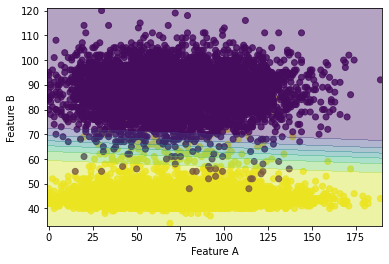

In [77]:
from matplotlib import pyplot as plot

# Plot the classifier results
cl1 = ['class 1']*len(sum1)
cl0 = ['class 0']*len(sum0)
df = pd.DataFrame(list(zip(np.concatenate((hole0, hole0)), np.concatenate((sum1,sum0)), 
                           np.concatenate((bound1,bound0)), np.concatenate((cl1, cl0)))),
               columns =['Hole', 'Sum', 'Boundary', 'Class'])

scikit_theta = np.hstack((md.intercept_, md.coef_[0]))
plot_theta = scikit_theta
# plot_theta = model.theta
plot_model = md        # Scikit
plot_model = model   # Scratch

fig = px.scatter_3d(df, x='Hole', y='Boundary', z=[0.5 for x in range(len(df['Sum']))], color='Class')
fig = plot_decision_boundary(plot_theta, fig, df, ['Hole', 'Boundary'])
fig.show()

plot = plot_decision_boundary_alt(df[['Hole', 'Boundary']], df['Class'], plot_theta, plot)
plot.show()

## We Can't Always Handcraft Effective Features!

These features worked well in distinguishing between 0s and 1s.    
But they don't perform very well between 2s and 3s, as illustrated below:

In [78]:
# Prepare features for different digits
no2 = train_X[train_y==2,:,:]
no3 = train_X[train_y==3,:,:]
# Sum feature
sum2 = np.sum(no2>0, (1,2))
sum3 = np.sum(no3>0, (1,2))
# Boundary feature
bound2 = np.array([getBoundaryPixels(i).sum() for i in no2])
bound3 = np.array([getBoundaryPixels(i).sum() for i in no3])
# Hole feature
hole2 = np.array([getHolePixels(i)[0].sum() for i in no2])
hole3 = np.array([getHolePixels(i)[0].sum() for i in no3])

In [79]:
# Create new dataframe
cl2 = [2]*len(sum2)
cl3 = [3]*len(sum3)
df_23 = pd.DataFrame(list(zip(np.concatenate((hole2, hole3)), np.concatenate((sum2,sum3)), 
                           np.concatenate((bound2,bound3)), np.concatenate((cl2, cl3)))),
               columns =['Hole', 'Sum', 'Boundary', 'Class'])
print(df_23.head())

   Hole  Sum  Boundary  Class
0    10  188        83      2
1    26  150        91      2
2    16  226        94      2
3     0  216        83      2
4    12  157        80      2


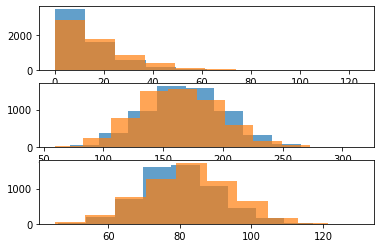

In [80]:
# Plot 1 feature at a time
# Holes
fig, axes = plt.subplots(3, 1)
axes[0].hist(hole2, alpha=0.7);
axes[0].hist(hole3, alpha=0.7);
# Sum
axes[1].hist(sum2, alpha=0.7);
axes[1].hist(sum3, alpha=0.7);
# Boundary
axes[2].hist(bound2, alpha=0.7);
axes[2].hist(bound3, alpha=0.7);

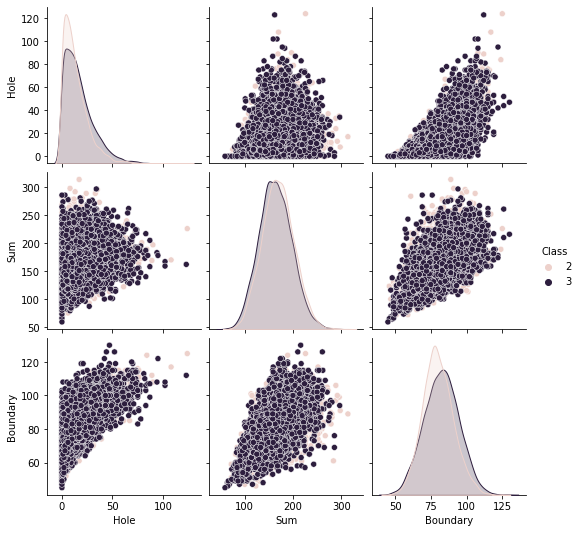

In [81]:
# Plot 2 features at a time
# Make Pair-Plot
import seaborn as sb
sb.pairplot(df_23, vars=df.columns[:-1], hue="Class")

All the more, we are just considering two classes here for binary classification. What if there were a 100 different classes of images?

It wouldn't be that easy to intuitively design features, plot them out and see if they work in most practical cases!

### Three Feature Classifier

In [ ]:
model= LogisticRegressionScratch()
model.fit(X_train, y_train, num_iter=150, lr=0.0015)
print(model.theta)
pred = model.predict(X_test)
accuracy = ((pred > 0.5) == y_test).mean()

print("The accuracy is %.3f" % accuracy)

[ 1.54267064  0.05015097 -0.0459415  -0.01438244]
The accuracy is 0.781


In [ ]:
# using a better optimizer
from sklearn.linear_model import LogisticRegression
md = LogisticRegression()
md.fit(X_train[:, 1:], y_train)
print(md.coef_)
pred = md.predict(X_test[:, 1:])
accuracy = np.sum(y_test==pred)/len(y_test)

print("The accuracy is %.3f" % accuracy)

[[-0.00439812 -0.06491956 -0.22579908]]
The accuracy is 0.993
